Taking a look at the generation of the cloud mask, and in particular the "dark pixels" generated by the scene classification layer

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
import sqlite3
from pathlib import Path
from datetime import datetime
from dateutil.relativedelta import relativedelta
from typing import List

In [37]:
base_folder = "/home/ebiederstadt/Documents/sentinel_cache/bbox-111.9314176_56.921209032_-111.6817217_57.105787570/2019-05-22"

dark_pixels = 2

dataset = rasterio.open(os.path.join(base_folder, "SCL.tif"))
scl = dataset.read(1)

path = Path(base_folder)
db_path = path.parent.absolute().joinpath("approximation.db")
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

In [82]:
def find_close_images(year, month, day):
    sql = """
SELECT year, month, day
FROM dates WHERE
    (year = ? OR year = ? OR year = ?) AND
    (month = ? OR month = ? OR month = ?) AND NOT
    (year = ? AND month = ? AND day = ?)
    ORDER BY year, month, day
"""
    current_date = datetime(year, month, day)
    previous_month = current_date - relativedelta(months=1)
    next_month = current_date + relativedelta(months=1)
    params = (current_date.year, previous_month.year, next_month.year, current_date.month, previous_month.month, next_month.month, current_date.year, current_date.month, current_date.day)
    cursor.execute(sql, params)
    result = cursor.fetchall()

    strings = []
    for x in result:
        date = datetime(x[0], x[1], x[2])
        strings.append(date.date().isoformat())
    return strings

def find_close_dates(year, month, day):
    sql = """
SELECT year, month, day
FROM dates WHERE
    (year = ? OR year = ? OR year = ?) AND
    (month = ? OR month = ? OR month = ?) AND NOT
    (year = ? AND month = ? AND day = ?)
    ORDER BY year, month, day
"""
    current_date = datetime(year, month, day)
    previous_month = current_date - relativedelta(months=1)
    next_month = current_date + relativedelta(months=1)
    params = (current_date.year, previous_month.year, next_month.year, current_date.month, previous_month.month, next_month.month, current_date.year, current_date.month, current_date.day)
    cursor.execute(sql, params)
    result = cursor.fetchall()

    return [datetime(x[0], x[1], x[2]) for x in result]


def get_nir_for_dates(dates: List[str], base_folder : Path):
    output = []
    for date in dates:
        dataset = rasterio.open(base_folder.joinpath(date).joinpath("B08.tif"))
        nir = dataset.read(1)
        output.append(nir)
    
    return output

dates_strings = find_close_images(2019, 5, 22)
dates = find_close_dates(2019, 5, 22)
base_folder = Path("/home/ebiederstadt/Documents/sentinel_cache/bbox-111.9314176_56.921209032_-111.6817217_57.105787570")

files = get_nir_for_dates(dates_strings, base_folder)

In [68]:
result = scl == dark_pixels

indicies = np.where(result)

for row, col in zip(*indicies):
    print(scl[row, col], row, col)

2 0 584
2 0 585
2 0 638
2 0 639
2 0 832
2 0 833
2 0 834
2 0 835
2 0 836
2 0 1003
2 0 1004
2 0 1005
2 0 1006
2 0 1007
2 0 1008
2 0 1009
2 0 1010
2 0 1011
2 1 389
2 1 390
2 1 584
2 1 585
2 1 638
2 1 639
2 1 832
2 1 833
2 1 834
2 1 835
2 1 836
2 1 1003
2 1 1004
2 1 1005
2 1 1006
2 1 1007
2 1 1008
2 1 1009
2 1 1010
2 1 1011
2 2 389
2 2 390
2 2 406
2 2 407
2 2 582
2 2 583
2 2 584
2 2 585
2 2 638
2 2 639
2 2 693
2 2 830
2 2 831
2 2 832
2 2 833
2 2 995
2 2 996
2 2 997
2 2 998
2 2 999
2 2 1000
2 2 1001
2 2 1002
2 3 389
2 3 390
2 3 406
2 3 407
2 3 582
2 3 583
2 3 638
2 3 639
2 3 640
2 3 641
2 3 693
2 3 830
2 3 831
2 3 832
2 3 833
2 3 995
2 3 996
2 3 997
2 3 998
2 3 999
2 3 1000
2 3 1001
2 3 1002
2 4 144
2 4 145
2 4 406
2 4 407
2 4 408
2 4 487
2 4 488
2 4 489
2 4 490
2 4 491
2 4 498
2 4 499
2 4 500
2 4 582
2 4 583
2 4 638
2 4 639
2 4 640
2 4 641
2 4 693
2 4 830
2 4 831
2 4 832
2 4 833
2 4 834
2 4 990
2 4 991
2 4 992
2 4 993
2 4 994
2 4 995
2 4 996
2 4 1136
2 4 1137
2 4 1138
2 5 144
2 5 145
2 5 4

In [109]:
# Take the first 10 invalid pixels and plot their nir values

first_few = indicies[:10]

data = []

i = 0
for row, col in zip(*indicies):
    i += 1
    if i > 5:
        break
    data_for_pixel = []
    for index, date in enumerate(dates_strings):
        data_for_pixel.append(files[index][row, col])
    data.append(data_for_pixel)

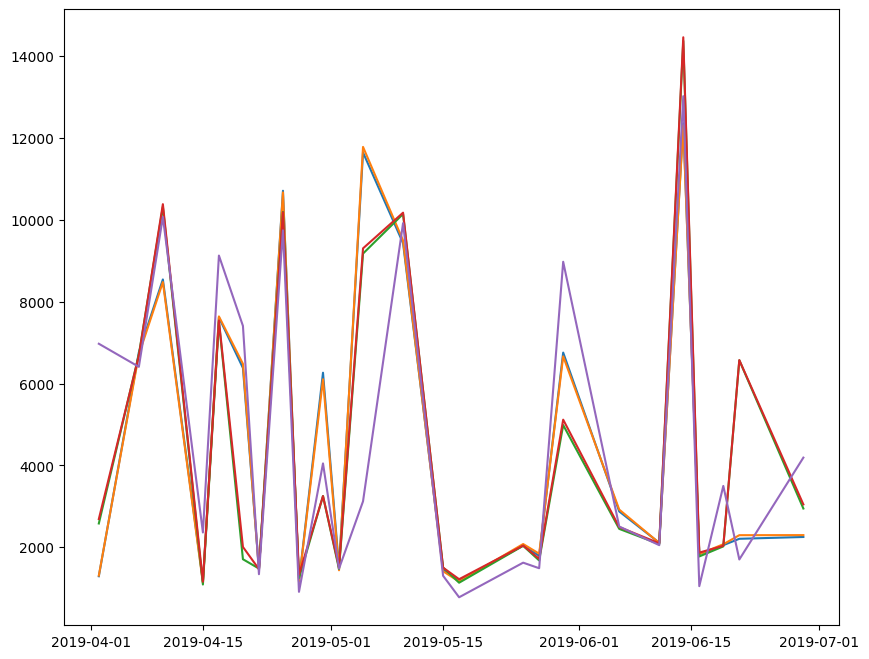

In [112]:
plt.figure(figsize=(10, 8))

for i, d in enumerate(data):
    plt.plot(dates, d)